# Introduction

* The data set is 13000+ images collected from the web
* with each image is manually labelled
* Data set is desigend for exploring creating and testing image recognition algorithms
* Lets try running an algorithm that can successfully identify faces in the dataset
  * after having been trained on similar faces.

# Libraries

In [39]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

from mtcnn.mtcnn import MTCNN
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people, fetch_lfw_pairs
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

# Data loading

* dataset source
* https://www.kaggle.com/datasets/jessicali9530/lfw-dataset 

In [9]:
# Images folder
data_folder = './data'
os.listdir(data_folder)

['pairs.csv',
 'matchpairsDevTest.csv',
 'people.csv',
 'lfw_readme.csv',
 'peopleDevTest.csv',
 'mismatchpairsDevTrain.csv',
 'lfw-deepfunneled',
 'matchpairsDevTrain.csv',
 'mismatchpairsDevTest.csv',
 'lfw_allnames.csv',
 'peopleDevTrain.csv']

In [23]:
lfw_allnames = pd.read_csv('./data/lfw_allnames.csv')
match_pairs_devTest = pd.read_csv('./data/matchpairsDevTest.csv')
mismatch_pairs_devTest = pd.read_csv('./data/mismatchpairsDevTest.csv')
match_pairs_devTrain = pd.read_csv('./data/matchpairsDevTrain.csv')
mismatch_pairs_devTrain = pd.read_csv('./data/mismatchpairsDevTrain.csv')
pairs = pd.read_csv('./data/pairs.csv')
pairs.head()


,name,imagenum1,imagenum2,Unnamed: 3
0,Abel_Pacheco,1,4,NaN
1,Akhmed_Zakayev,1,3,NaN
2,Akhmed_Zakayev,2,3,NaN
3,Amber_Tamblyn,1,2,NaN
4,Anders_Fogh_Rasmussen,1,3,NaN


In [24]:
# clean up tidy pairs 

pairs = pairs.rename(columns={'name':'name1', 'Unnamed: 3':'name2'})
matched_pairs = pairs[pairs['name2'].isnull()].drop('name2', axis=1)
matched_pairs

,name1,imagenum1,imagenum2
0,Abel_Pacheco,1,4
1,Akhmed_Zakayev,1,3
2,Akhmed_Zakayev,2,3
3,Amber_Tamblyn,1,2
4,Anders_Fogh_Rasmussen,1,3
...,...,...,...
5695,Vladimir_Voltchkov,1,2
5696,Wang_Yi,1,2
5697,Zafarullah_Khan_Jamali,1,2
5698,Zhu_Rongji,1,3


In [29]:
mismatched_pairs = pairs[pairs['name2'].notnull()]
mismatched_pairs.head()

,name1,imagenum1,imagenum2,name2
300,Abdel_Madi_Shabneh,1,Dean_Barker,1.0
301,Abdel_Madi_Shabneh,1,Giancarlo_Fisichella,1.0
302,Abdel_Madi_Shabneh,1,Mikhail_Gorbachev,1.0
303,Abdul_Rahman,1,Portia_de_Rossi,1.0
304,Abel_Pacheco,1,Jong_Thae_Hwa,2.0


In [28]:
people = pd.read_csv('./data/people.csv')
people = people[people.name.notnull()]
people.head()

,name,images
0,Abdel_Madi_Shabneh,1.0
1,Abdul_Rahman,1.0
2,Abel_Pacheco,4.0
3,Adriana_Lima,1.0
4,Afton_Smith,1.0


In [30]:
people_devTest = pd.read_csv('./data/peopleDevTest.csv')
people_devTrain = pd.read_csv('./data/peopleDevTrain.csv')
people_devTrain.head()

,name,images
0,AJ_Cook,1
1,Aaron_Eckhart,1
2,Aaron_Patterson,1
3,Aaron_Peirsol,4
4,Aaron_Pena,1


# exploratory data anlaysis

In [32]:
print(f'There are {lfw_allnames.shape[0]} people in the dataset')

There are 5749 people in the dataset


## data reshaping and train/test split

* define the task more clearly before we create the train/test split
* the flow of the project should be as follows
  * build a model on the training data that can predict the names associated with images
    * the training set should incorporate multiple images of some individualas, 
    * to equip the model with knowledge of how to deal with the same face in different situations
  * Test the model on new images and predict the identity
    * the test set needs to incorporate some individuals that we have seen in the training set,
    * although not the same images, and some individuals that we havent
    * to test the algorithms accuracy
* therefore we need to split the data into training and test data

In [38]:
# shape data frame so there is a row per image, matched to relevant jpg file

image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name+'/'+image_paths.name+'_'+image_paths.image_path+'.jpg'
image_paths = image_paths.drop('images', axis=1)
image_paths.head()


,name,image_path
0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg


In [40]:
# random sample of 80% of people for training, 20% for testing
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2, random_state=143)
lfw_train = lfw_train.reset_index(drop=True)
lfw_test = lfw_test.reset_index(drop=True)  
lfw_test.head()

,name,image_path
0,Alastair_Campbell,Alastair_Campbell/Alastair_Campbell_0003.jpg
1,Yao_Ming,Yao_Ming/Yao_Ming_0006.jpg
2,Recep_Tayyip_Erdogan,Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0015...
3,Elena_Bovina,Elena_Bovina/Elena_Bovina_0001.jpg
4,Parris_Glendening,Parris_Glendening/Parris_Glendening_0001.jpg


In [43]:
# make sure there is a mix of seen and unseen people in the test set
print(f'There are {len(set(lfw_train.name).intersection(set(lfw_test.name)))} \
    people in both the training and test sets')
print(f'There are {len(set(lfw_test.name).difference(set(lfw_train.name)))} \
    people in the test set but not the training set')


There are 841     people in both the training and test sets
There are 846     people in the test set but not the training set


## image format exploration

In [50]:
widths = []
heights = []
files = image_paths.image_path
for file in files:
    img = Image.open('data/lfw-deepfunneled/lfw-deepfunneled'+ '/' +file)
    widths.append(img.size[0])
    heights.append(img.size[1])

pd.DataFrame({'width':widths, 'height':heights}).describe()
## all images are 250x250 pixels

,width,height
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


## further data exploration

<Axes: title={'center': 'Top 10 people by number of images'}, ylabel='name'>

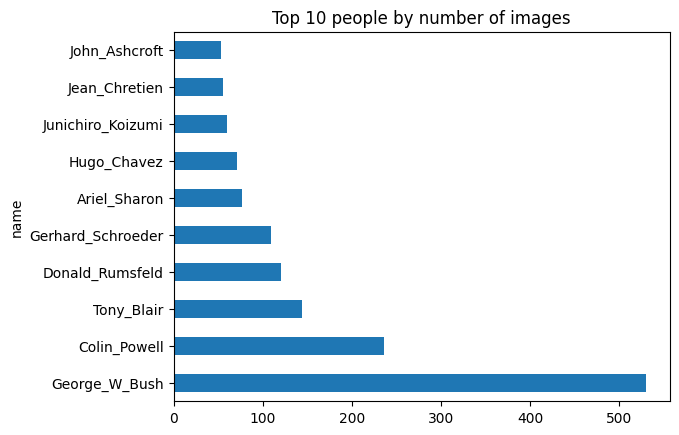

In [49]:
image_paths.name.value_counts()[:10].plot(kind='barh', title='Top 10 people by number of images')


* lets do a quick sanity check and visualize a sample iamge

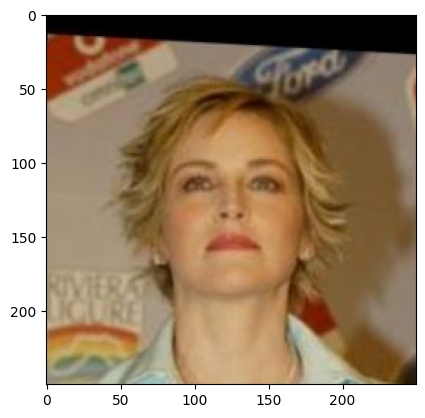

In [52]:
img = Image.open('data/lfw-deepfunneled/lfw-deepfunneled/'+str(lfw_train.image_path[10]))
plt.imshow(img)

# Evaluation metric decisions

* what is a successful model means?
* Accuracy is defined as : acc = (true pos + true neg)/ total count
  * It is the proportion of all predicitions that are correct.
  * accuracy is a useful indicator that our model performs well
* Precision
* Recall
* which of these are useful ?
* Here, where image recognition is being utilized in the entertainment sphere, the key outputs
  * are likely to be in image labelling for new servcies and video annotation for live brodcast.
  * both services are primarily intersted in making sure any allocated labels are correct.
  * missing labels are less problematic than incorrect labels,
  * especially for building public trust in the system and avoiding embarrasing errors,
  * so the cost of false positives is likely to be higher.
  * Thus , while we still consider **recall** for each predicted class,
  * we primarily focus on **precision** in our model results.

# Model construction

## Basic model : detecting faces